<a href="https://colab.research.google.com/github/AlexanderVinarsky/Muography_Research/blob/main/Muography_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras
!pip install tensorflow

In [3]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
from scipy.ndimage.measurements import label, find_objects
import re
from PIL import Image

from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

from google.colab import files

<ipython-input-3-13c12dcbdb77>:6: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label, find_objects
<ipython-input-3-13c12dcbdb77>:6: DeprecationWarning: Please use `find_objects` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label, find_objects


In [4]:
df = np.load('drive/MyDrive/Muons/responses_norm.npy')
df = pd.DataFrame(df[-2])
df.style.background_gradient(cmap='plasma', axis=None)

In [5]:
def get_coordinates(df, threshold = 0.30):
  labels, num_labels = label(df > threshold)
  regions = find_objects(labels)
  coordinates_raw = []

  for i in range(num_labels):
    temp=[]
    x_slice = re.findall(r'\d+', str(regions[i][1]))
    temp.append(int(x_slice[0]))
    temp.append(int(x_slice[1]))
    y_slice = re.findall(r'\d+', str(regions[i][0]))
    temp.append(int(y_slice[0]))
    temp.append(int(y_slice[1]))
    coordinates_raw.append(temp)
  
  return coordinates_raw

In [6]:
def clean(df, coordinates_raw, threshold = 0.3, min_size = 4, max_size=32):
    coordinates = [i for i in coordinates_raw if (i[1] - i[0] > min_size and i[3]-i[2]>min_size) and (i[1] - i[0] <= max_size and i[3]-i[2] <= max_size)]
    coordinates_raw = [i for i in coordinates_raw if (i[1] - i[0] > max_size or i[3]-i[2] > max_size)]
    return coordinates
    if (len(coordinates_raw)>0):
      threshold += 0.05
      temp_coordinates = []
      for coordinate in coordinates_raw:
        temp_df = df.iloc[coordinate[2]:coordinate[3], coordinate[0]:coordinate[1]]
        temp_temp_coordinates = get_coordinates(temp_df, threshold)
        for coordinate in temp_temp_coordinates:
          coordinate[2] += temp_df.index[0]
          coordinate[3] += temp_df.index[0]
          coordinate[0] += temp_df.columns[0]
          coordinate[1] += temp_df.columns[0]
        temp_coordinates += get_coordinates(df, threshold)
      coordinates+=(clean_and_divide(temp_df, temp_coordinates, threshold, min_size, max_size))
      return coordinates
    else:
      return coordinates

In [7]:
coordinates = clean(df, get_coordinates(df))

In [8]:
shapes=[]
for i in range(len(coordinates)):
  shapes.append(df.iloc[coordinates[i][2]:coordinates[i][3], coordinates[i][0]:coordinates[i][1]])

In [10]:
for i in range(len(coordinates)):
  coordinates[i] = [coordinates[i][0], coordinates[i][1]-1, coordinates[i][2], coordinates[i][3]-1]

In [11]:
for i in range(len(coordinates)):
  print(i)
  print(coordinates[i])

0
[57, 82, 0, 5]
1
[254, 282, 0, 8]
2
[28, 39, 1, 11]
3
[90, 94, 2, 6]
4
[109, 130, 2, 21]
5
[99, 108, 5, 11]
6
[183, 197, 5, 15]
7
[204, 225, 6, 22]
8
[144, 167, 7, 13]
9
[51, 56, 8, 12]
10
[11, 18, 12, 17]
11
[30, 43, 14, 19]
12
[266, 284, 14, 23]
13
[140, 166, 17, 22]
14
[80, 110, 22, 32]
15
[250, 263, 24, 33]
16
[201, 212, 26, 33]
17
[21, 26, 30, 34]
18
[219, 246, 31, 44]
19
[5, 14, 33, 40]
20
[256, 277, 35, 40]
21
[60, 78, 39, 44]


In [20]:
shapes[2].style.background_gradient(cmap='plasma', axis=None)

,28,29,30,31,32,33,34,35,36,37,38,39,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.107902,0.108899,0.121951,0.136910,0.168860,0.203575,0.238104,0.270391,0.289616,0.297281,0.304004,0.295349,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.141223,0.161895,0.194749,0.228558,0.277634,0.327164,0.346521,0.373228,0.385911,0.387536,0.345520,0.281854,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.139189,0.166960,0.213097,0.264505,0.346276,0.432907,0.473941,0.498768,0.506456,0.414018,0.344183,0.281235,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.038190,0.079573,0.139019,0.191260,0.274094,0.362150,0.440866,0.495290,0.506648,0.414018,0.344183,0.281235,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.170464,0.213783,0.274825,0.327534,0.397277,0.471564,0.537520,0.592321,0.572309,0.466081,0.382804,0.306654,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.287293,0.313875,0.356702,0.390385,0.441392,0.497767,0.545538,0.582498,0.480451,0.368369,0.279128,0.209729,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.340767,0.353554,0.382701,0.403064,0.427024,0.465866,0.493197,0.507440,0.500167,0.446739,0.366969,0.305898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.248358,0.306077,0.362241,0.373035,0.379504,0.399971,0.408785,0.401888,0.372992,0.347042,0.326681,0.298435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.303762,0.325397,0.321994,0.305462,0.289465,0.286941,0.273335,0.261434,0.250845,0.239993,0.241222,0.241993,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.278877,0.325397,0.321994,0.305462,0.289465,0.286941,0.273335,0.261434,0.250845,0.239993,0.241222,0.241993,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [16]:
answers=[]
for i in range(len(coordinates)):
  answers.append(False)

In [17]:
answers[0] = False
answers[1] = False
answers[2] = True
answers[3] = False
answers[4] = True
answers[5] = True
answers[6] = True
answers[7] = False
answers[8] = True
answers[9] = True
answers[10] = True
answers[11] = True
answers[12] = True
answers[13] = True
answers[14] = True
answers[15] = True
answers[16] = True
answers[17] = True
answers[18] = True
answers[19] = True
answers[20] = False
answers[21] = False

In [ ]:
pd.Series 
for i in range(len(shapes)):
  new_cols = []
  new_cols.append(str(len(shapes[i].columns[-1:])))
  for j in range(32-len(shapes[i].columns)):
    new_cols.append(str(j+1))

  new_data = {col: [0]*len(shapes[i]) for col in new_cols}

  shapes[i] = shapes[i].assign(**new_data)
  for j in range(32-len(shapes[i])):
    shapes[i]= shapes[i].append(pd.Series(0.0, index=shapes[i].columns), ignore_index=True)

In [ ]:
for i in range(len(shapes)):
  picture = plt.figure(figsize=(1.6, 1.6), dpi=300, frameon=False, facecolor=None)
  plt.imshow(shapes[i], cmap='gray', vmin=0, vmax=1)
  plt.gca().set_axis_off()
  plt.margins(0,0)
  plt.axis('off')
  picture.show()
  if (answers[i]):
    picture.savefig('/content/drive/MyDrive/Muons/Figures/true/figure' + str(i) + '.jpeg', bbox_inches='tight',  pad_inches=0.0, dpi=26)
  else:
    picture.savefig('/content/drive/MyDrive/Muons/Figures/false/figure' + str(i) + '.jpeg', bbox_inches='tight', pad_inches=0.0, dpi=26)

# Нейросеть

In [25]:
datagen=ImageDataGenerator(rescale=1./255)

In [23]:
training_set = datagen.flow_from_directory(
    '/content/drive/MyDrive/Muons/Figures',
    target_size=(32, 32),
    batch_size=1,
    class_mode='categorical')

Found 22 images belonging to 2 classes.


In [24]:
TrainClasses=training_set.class_indices

ResultMap={}
for shapeValue,shapeName in zip(TrainClasses.values(),TrainClasses.keys()):
    ResultMap[shapeValue]=shapeName

In [27]:
classifier = Sequential()
classifier.add(Convolution2D(32, kernel_size=(3,3), strides=(1,1), input_shape=(32,32,3), activation='relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))
classifier.add(Convolution2D(64, kernel_size=(3,3), strides=(2,2), activation='relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))
classifier.add(Flatten())
classifier.add(Dense(576,activation='relu'))
classifier.add(Dense(2, activation='softmax'))
classifier.compile(loss='categorical_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])

In [28]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 576)               3

In [29]:
model_history=classifier.fit(training_set, steps_per_epoch=len(training_set), epochs=10)

Epoch 1/10
22/22 [==============================] - 1s 9ms/step - loss: 0.7635 - accuracy: 0.6364
Epoch 2/10
22/22 [==============================] - 0s 10ms/step - loss: 0.6360 - accuracy: 0.7273
Epoch 3/10
22/22 [==============================] - 0s 10ms/step - loss: 0.7512 - accuracy: 0.7273
Epoch 4/10
22/22 [==============================] - 0s 9ms/step - loss: 0.6460 - accuracy: 0.7273
Epoch 5/10
22/22 [==============================] - 0s 8ms/step - loss: 0.6007 - accuracy: 0.7273
Epoch 6/10
22/22 [==============================] - 0s 9ms/step - loss: 0.5564 - accuracy: 0.7273
Epoch 7/10
22/22 [==============================] - 0s 10ms/step - loss: 0.5135 - accuracy: 0.6818
Epoch 8/10
22/22 [==============================] - 0s 9ms/step - loss: 0.4146 - accuracy: 0.8182
Epoch 9/10
22/22 [==============================] - 0s 9ms/step - loss: 0.4554 - accuracy: 0.6818
Epoch 10/10
22/22 [==============================] - 0s 9ms/step - loss: 0.3645 - accuracy: 0.8182


In [30]:
testImage = '/content/drive/MyDrive/Muons/Figures/false/figure21.jpeg'

test_image=load_img(testImage, target_size=(32,32))
test_image=img_to_array(test_image)
test_image=np.expand_dims(test_image,axis=0)
result=classifier.predict(test_image,verbose=0)

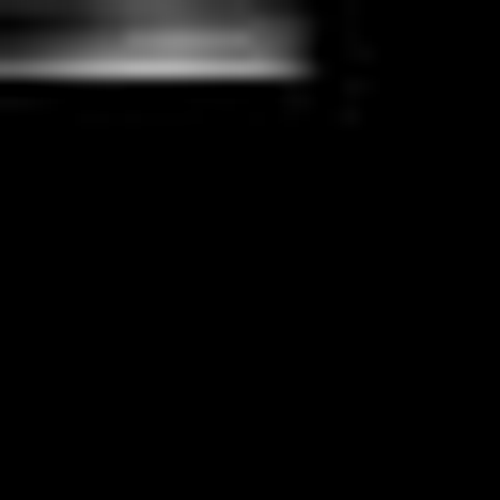

In [31]:
image = Image.open(testImage)
image = image.resize((500, 500))
image

In [32]:
print(ResultMap[np.argmax(result)])

false
